
# Predicción del precio de la vivienda mediante aprendizaje automático

## Trabajo Final De Master

## Universidad de Valladolid

#### Bungisa Beto Bibeyi

### Análisis exploratorio de datos

### Librerias

In [300]:
import os
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [301]:
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Arnold\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [302]:
pip install folium

In [303]:
import folium
from folium import plugins
from folium.plugins import HeatMap

In [304]:
nltk.download('stopwords')
stop_words_es = set(stopwords.words(['spanish','english']))
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Arnold\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Arnold\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Arnold\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [305]:
from collections import Counter

### FUNCIONES

In [306]:
def mostrar_conteos_categorias(df,columnas_excluidas):
    columnas_categoricas = viviendas_df.select_dtypes(exclude=[np.number]).drop(columns=columnas_excluidas).columns
    for columna in columnas_categoricas:
        conteo = df[columna].value_counts(dropna=False)
        
        
        plt.figure(figsize=(8, 6))
        sns.countplot(x=columna, data=df, palette='viridis')
        plt.title(f'Conteo {columna}')
        plt.xlabel('Categoría')
        plt.ylabel('Número de ocurrencias')
        plt.show()

In [307]:
def mostrar_conteos_numericos(df):
    columnas_numericas = viviendas_df.select_dtypes(include=[np.number]).columns
    for columna in columnas_numericas:
        conteo = df[columna].value_counts(dropna=False)
        
        
        plt.figure(figsize=(8, 6))
        sns.countplot(x=columna, data=df, palette='viridis')
        plt.title(f'Conteo {columna}')
        plt.xlabel('Numérica')
        plt.ylabel('Número de ocurrencias')
        plt.show()

In [308]:
def mostrar_boxplot (df,columna):
    
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    min_val = df[columna].min()
    max_val = df[columna].max()


    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[columna], color='lightblue', linewidth=1.2)

    plt.xlabel(columna)
    plt.title('Boxplot {}'.format(columna))


    # Q1
    plt.axvline(Q1, color='red', linestyle='--', label=f'Q1 ({Q1:.2f})')
    # mediana
    plt.axvline(df[columna].median(), color='green', linestyle='--', label=f'Mediana ({df[columna].median():.2f})')
    # Q3
    plt.axvline(Q3, color='blue', linestyle='--', label=f'Q3 ({Q3:.2f})')
    # mínimo y máximo
    plt.axvline(min_val, color='purple', linestyle=':', label=f'Mínimo ({min_val:.2f})')
    plt.axvline(max_val, color='orange', linestyle=':', label=f'Máximo ({max_val:.2f})')

    plt.legend()
    plt.show()
    

In [309]:
def procesar_texto(texto,stopWordsES):
    texto = re.sub(r'\W+', ' ', texto)  # Eliminar caracteres no alfanuméricos
    texto = texto.lower()  # Convertir a minúsculas
    tokens = word_tokenize(texto)  # Tokenizar
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stopWordsES]
    return ' '.join(tokens)

In [310]:
def valores_mas_frecuentes(df,columna,top_n):    
    all_tokens = df.explode()
    contador_palabra = Counter(all_tokens)
    contador_palabra_df = pd.DataFrame(contador_palabra.items(), columns=['Valores', 'Frecuencia']).sort_values(by='Frecuencia', ascending=False)
    contador_palabra_df.set_index('Valores').head(top_n).plot(kind='bar')
    plt.xlabel('Valores')
    plt.ylabel('Frecuencia')
    plt.title('valores más frecuentes {}'.format(columna))
    plt.show()

In [311]:
def limpiar_texto(texto, longitud_minima):
    texto_limpio = re.sub(r'[^a-zA-Z\s]', '', texto)
    palabras = [palabra for palabra in texto_limpio.split() if len(palabra) >= longitud_minima]
    return ' '.join(palabras)

In [312]:
def frecuencia_palabras(df,columna,top_n,longitud_minima):
    data_df = df.apply(lambda texto: limpiar_texto(texto, longitud_minima))
    tokens_df = data_df.apply(nltk.tokenize.word_tokenize)
    filtrado_df = tokens_df.apply(lambda x: [ palabra for palabra in x if palabra not in stop_words_es ])
    
    palabras = filtrado_df.tolist()
    palabras = [ palabra for list_ in palabras for palabra in list_]
    palabras_dist = nltk.FreqDist(palabras)
    frecuencia_palabras_df = pd.DataFrame(palabras_dist.most_common(top_n), columns=['palabra','frecuencia'])
    frecuencia_palabras_df.set_index('palabra').head(top_n).plot(kind='bar')
    plt.xlabel('palabra')
    plt.ylabel('frecuencia')
    plt.title('palabra más frecuentes {}'.format(columna))
    plt.show()   

In [313]:
def eliminarOutliers(df,columna):
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[columna] >= lower_bound) & (df[columna] <= upper_bound)]


def eliminarOutliersColumnas(df,columnas):
    for columna in columnas:
        df = eliminarOutliers(df, columna)
    return df

In [314]:
def getDatosFaltantes(data_df):
    
    porcentaje_datos_faltantes_df = data_df.isnull().mean() * 100
    porcentaje_datos_faltantes_df = porcentaje_datos_faltantes_df[porcentaje_datos_faltantes_df > 0]
    porcentaje_datos_faltantes_df = porcentaje_datos_faltantes_df.reset_index()
    porcentaje_datos_faltantes_df.columns = ['Columnas', 'Porcentajes']
    porcentaje_datos_faltantes_df = porcentaje_datos_faltantes_df.sort_values(by='Porcentajes', ascending=False)
    return porcentaje_datos_faltantes_df

In [315]:
def clasificarPlanta(valor):
    if isinstance(valor, str):
        if valor.lower() == 'chalet':
            return 'alto'
        elif valor.lower() == 'bj':
            return 'bajo'
        elif valor.lower() == 'countryhouse':
            return 'muy alto'
        else:
            try:
                valor_num = int(valor)
                if valor_num > 4:
                    return 'mediano'
                else:
                    return 'intermedio'
            except ValueError:
                return valor
    elif isinstance(valor, (int, float,)):
        if valor > 4:
            return 'mediano'
        else:
            return 'intermedio'
    else:
        return valor
    

In [316]:
def transformarMiniscula(data_df,columnas):
    for col in columnas:
        data_df[col] = data_df[col].str.strip().str.lower()
    return data_df

In [317]:
def clasificar_tamaño(valor):
    if valor <= 80:
        return 'pequeño'
    elif valor <= 150:
        return 'mediano'
    elif valor <= 300:
        return 'grande'
    else:
        return 'muy grande'

### Formato conjunto de datos (CSV)

| price  | propertyType | size | rooms | bathrooms | address             | municipality | description                        | status  | priceByArea | hasParkingSpace | isParkingSpaceIncludedInPrice | typology    | subtitle                           | title                            | floor | hasLift | postcode |
|--------|--------------|------|-------|-----------|---------------------|--------------|------------------------------------|---------|-------------|-----------------|------------------------------|-------------|------------------------------------|----------------------------------|-------|---------|----------|
| 300000 | Departamento | 85   | 3     | 2         | 123 Calle Principal | Barcelona    | Departamento espacioso con balcón  | En venta | 3529        | Sí              | No                           | Residencial | Hermoso departamento de 3 habitaciones | Gran oportunidad en el centro de la ciudad | 3     | Sí      | 08001    |
| 450000 | Casa         | 120  | 4     | 3         | 456 Calle Elm        | Madrid       | Casa familiar con jardín            | Vendida  | 3750        | Sí              | Sí                           | Residencial | Hermosa casa familiar con jardín  | Vendida a un buen precio               | 2     | Sí      | 28001    |


### Descripción de los campos

**price:** Precio de la propiedad  
**propertyType:** Tipo de propiedad como apartamentos, casa, oficina  
**size:** Tamaño de la vivienda en metros cuadrados  
**rooms:** Número de habitaciones en la vivienda  
**bathrooms:** Número de baños en la vivienda  
**address:** Dirección completa de la vivienda  
**municipality:** Municipio donde se encuentra la vivienda  
**description:** Descripción textual de la vivienda  
**status:** Estado de la vivienda como disponible, reservado  
**priceByArea:** Precio por metro cuadrado de la vivienda  
**hasParkingSpace:** Indica si la propiedad incluye espacio de estacionamiento  
**isParkingSpaceIncludedInPrice:** Indica si el espacio de estacionamiento está incluido en el precio de la propiedad  
**typology:** Tipología detallada de la vivienda como apartamento, casa.  
**subtitle:** Subtítulo sugerido para el anuncio  
**title:** Título sugerido para el anuncio  
**floor:** Número del piso en el que se encuentra la vivienda  
**hasLift:** Indica si el edificio cuenta con ascensor  
**postcode:** codigo postal
**latitude:** Coordenada de latitud de la vivienda  
**longitude:** Coordenada de longitud de la vivienda 

### Lectura de los datos

In [318]:
viviendas_df = pd.read_csv('data_staging/viviendas_limpieza_df_parte_2.csv')

### Exploracion inicial de los datos

La estructura del fichero json leido es heterogeneos o variable por lo que los objetos pueden tener diferentes conjuntos
claves o variar en los tipos de valores asociados a estas claves.  
A la hora de cargar los datos se rellenan con valores nulos(NaN) los campos que no estan presentes en todos los objetos.  

En esta fase se realizar una observacion inicial sobre el conjunto de datos donde se puede determinar lo siguiente:

 - El numero de registros y columnas que tiene el conjunto de datos
 - Como se presentan los datos y si se han cargado correctamente
 - Renombrar el nombre de las columnas si se considera necesario para mejorar el analisis del conjunto de datos

In [319]:
viviendas_df.shape

(4632, 20)

##### Observaciones:
 - Podemos ver que el conjunto de datos cargado consta de 4517 registros y 20 columnas

#### Información del conjunto de datos

In [320]:
viviendas_df[viviendas_df.columns[0:20]].head()

,price,propertyType,size,rooms,bathrooms,address,municipality,latitude,longitude,description,status,priceByArea,hasParkingSpace,isParkingSpaceIncludedInPrice,typology,subtitle,title,floor,exterior,hasLift
0,1125000.0,chalet,500.0,10,6,ciudalcampo,ciudalcampo,40.634800,-3.595819,ideal para dos familias. casa construida a fin...,good,2250.0,1,1,chalet,ciudalcampo,casa independiente,alto,1,0
1,785000.0,chalet,800.0,3,3,la berzosilla,torrelodones,40.583729,-3.949424,torrelodones. gran chalet independiente a estr...,good,981.0,0,0,chalet,"la berzosilla, torrelodones",casa independiente,alto,1,0
2,2950000.0,chalet,500.0,6,4,barrio el plantío,madrid,40.476875,-3.825426,ambassador les ofrece un inmueble muy especial...,good,5900.0,1,1,chalet,"el plantío, madrid",casa independiente,alto,1,0
3,795000.0,flat,201.0,2,2,"calle garcia quintanilla, 4",madrid,40.444223,-3.642674,"""tiempo para el detalle""time for detail""zeit f...",newdevelopment,3955.0,1,1,flat,"concepción, madrid","piso en calle garcia quintanilla, 4",intermedio,1,1
4,4000000.0,chalet,800.0,5,8,barrio prado largo,pozuelo de alarcón,40.427107,-3.847710,residencial noroeste vende este exclusivo chal...,good,5000.0,0,0,chalet,"prado largo, pozuelo de alarcón",casa independiente,alto,1,0


### Análisis exploratorio de los datos

El objetivo es comprender los datos y comenzar a encontrar respuestas respecto a la variable objetivo, que es el precio de la vivienda. Para ello, se llevarán a cabo las siguientes fases:

1. **Análisis univariado**: Evaluar cada variable por separado para entender sus características y distribuciones.
2. **Análisis bivariado**: Examinar la relación entre pares de variables y cómo estas interacciones afectan a la variable objetivo.

#### Visión general de la estructura de datos

In [321]:
viviendas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4632 entries, 0 to 4631
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   price                          4632 non-null   float64
 1   propertyType                   4632 non-null   object 
 2   size                           4632 non-null   float64
 3   rooms                          4632 non-null   int64  
 4   bathrooms                      4632 non-null   int64  
 5   address                        4632 non-null   object 
 6   municipality                   4632 non-null   object 
 7   latitude                       4632 non-null   float64
 8   longitude                      4632 non-null   float64
 9   description                    4632 non-null   object 
 10  status                         4632 non-null   object 
 11  priceByArea                    4632 non-null   float64
 12  hasParkingSpace                4632 non-null   i

#### Observaciones:
- A simple vista, se puede observar que las columnas **`hasParkingSpace`** y **`isParkingSpaceIncludedInPrice`**, que son de tipo booleano, tienen la mitad de sus valores como nulos.

### Análisis univariable

El objetivo es estimar el precio de las viviendas, por lo que la variable objetivo en el análisis es el precio de las viviendas. En esta fase, se llevará a cabo un análisis univariado tanto de las variables predictoras como de la variable objetivo. Este análisis permitirá comprender la distribución y las características individuales de cada variable, lo cual es crucial para una interpretación precisa de los datos.

Este análisis permite explorar las propiedades específicas de las variables, como su tendencia central, dispersión y posibles anomalías.

### 1. Variables Numéricas

#### Variable Price

Calculamos las estadísticas descriptivas de la columna price, incluyendo la media, mediana, desviación estándar, mínimo, máximo y percentiles, para entender su distribución y características.

In [322]:
estadisticas_descriptivas= viviendas_df['price'].describe()
print(estadisticas_descriptivas.apply(lambda x: f"{x:.2f}"))

count        4632.00
mean       662225.50
std       1045309.05
min         19800.00
25%        204975.00
50%        345650.00
75%        563499.75
max      15000000.00
Name: price, dtype: object


#### Visualización de la distribución( Histograma)

Representamos la distribución de la columna price utilizando una visualización que combina un histograma con una estimación de densidad de kernel (KDE). Este enfoque permite observar la frecuencia de los precios en diferentes intervalos junto con una curva suave que estima la distribución subyacente de los datos.

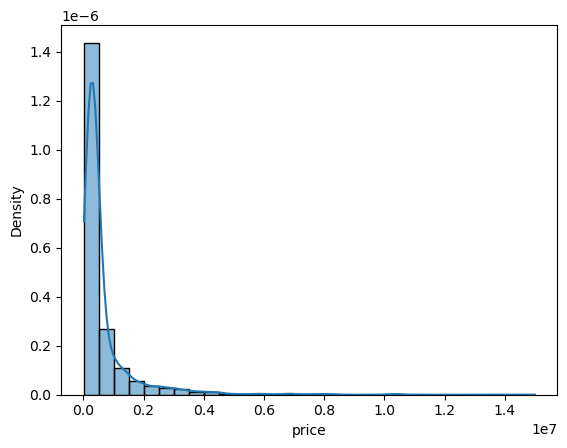

In [323]:
sns.histplot(viviendas_df['price'],kde=True, stat='density', bins=30);

#### Visualización de la distribución (Boxplot)

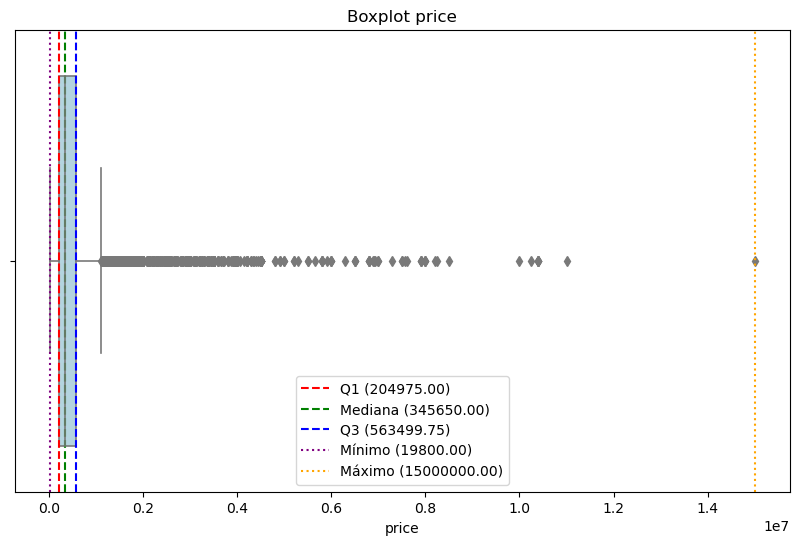

In [324]:
mostrar_boxplot(viviendas_df,'price')

##### Observaciones:

En el análisis de la variable numérica price, se evidencia que el precio promedio de las viviendas es considerablemente alto. Sin embargo, la desviación estándar revela una notable variabilidad en los precios, indicando que existe una amplia gama de valores. El rango de precios abarca desde niveles relativamente bajos hasta cifras muy elevadas, lo que sugiere una diversidad significativa en los tipos de viviendas incluidas en el conjunto de datos.
 
 Se observa una diferencia considerable entre la media y la mediana del precio, con una media de 671.948,36 y una mediana de 349.900,00. Esta diferencia indica un sesgo hacia la derecha en la distribución de los precios.

#### Variable size

Calculamos las estadísticas descriptivas de la columna price, incluyendo la media, mediana, desviación estándar, mínimo, máximo y percentiles, para entender su distribución y características.

In [325]:
viviendas_df['size'].describe()

count      4632.000000
mean        227.765328
std        1633.400507
min          14.000000
25%          79.000000
50%         120.000000
75%         235.000000
max      110000.000000
Name: size, dtype: float64

#### Visualización de la distribución( Histograma)

Representamos la distribución de la columna price utilizando una visualización que combina un histograma con una estimación de densidad de kernel (KDE)

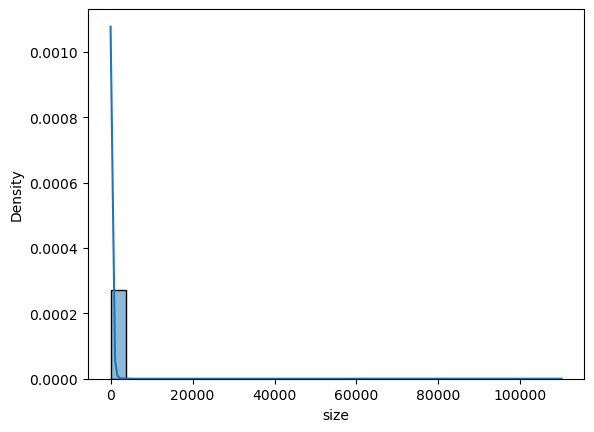

In [326]:
sns.histplot(viviendas_df['size'],kde=True, stat='density', bins=30);

#### Visualización de la distribución (Boxplot)

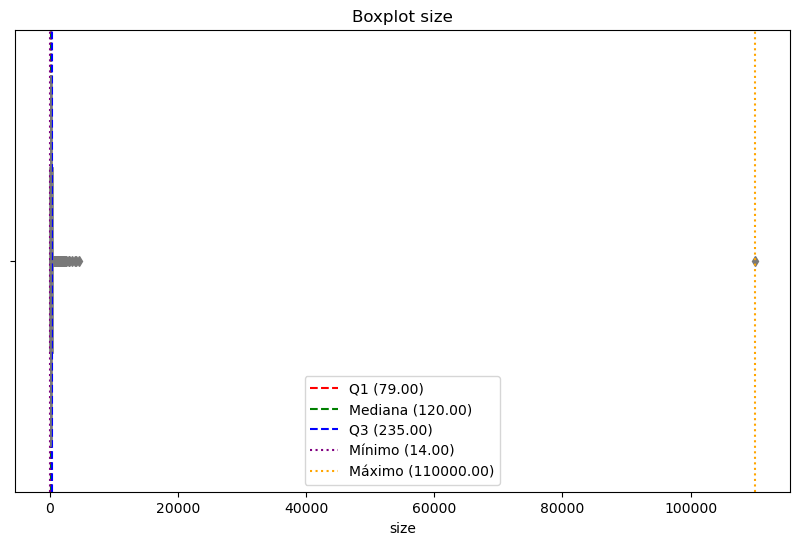

In [327]:
mostrar_boxplot(viviendas_df,'size')

#### Observaciones:

 - En el análisis de la variable numérica size, se observa que el tamaño promedio de las viviendas es significativamente alto, y la desviación estándar también es elevada, lo que indica una considerable variabilidad en los tamaños de las viviendas. El rango de tamaños es muy amplio, abarcando desde viviendas de dimensiones muy reducidas hasta viviendas extremadamente grandes. Se destaca que la media del tamaño (229,33) es considerablemente mayor que la mediana (120), lo que sugiere que los valores extremos altos están influyendo en el promedio. Esta característica podría afectar negativamente el rendimiento del modelo.

#### Variable rooms

Calculamos las estadísticas descriptivas de la columna price, incluyendo la media, mediana, desviación estándar, mínimo, máximo y percentiles, para entender su distribución y características.

In [328]:
viviendas_df['rooms'].describe()

count    4632.000000
mean        3.252375
std         1.941265
min         0.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        35.000000
Name: rooms, dtype: float64

#### Visualización de la distribución( Histograma)

Representamos la distribución de la columna price utilizando una visualización que combina un histograma con una estimación de densidad de kernel (KDE)

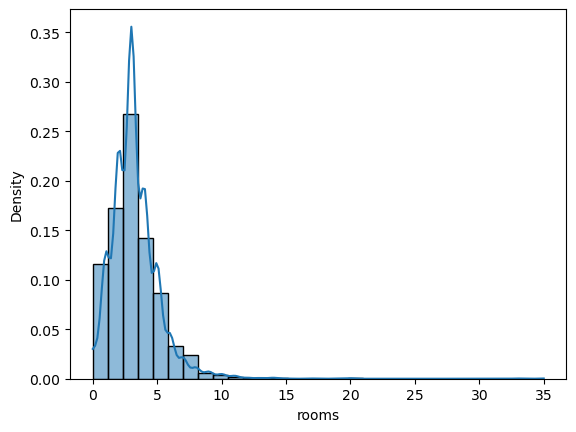

In [329]:
sns.histplot(viviendas_df['rooms'],kde=True, stat='density', bins=30);

#### Visualización de la distribución (Boxplot)

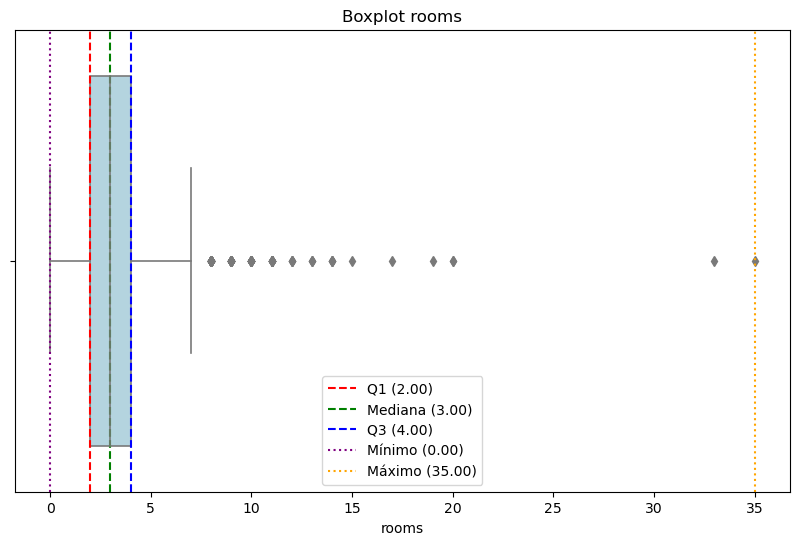

In [330]:
mostrar_boxplot(viviendas_df,'rooms')

#### Observaciones:

 - En el análisis de la variable numérica rooms, se observa que la mayoría de las viviendas tienen entre 2 y 4 habitaciones, con un promedio de 3,26 habitaciones. La desviación estándar es alta, lo que indica que existen algunas viviendas con un número de habitaciones significativamente mayor que la media. Además, el rango máximo también es elevado, indicando la presencia de viviendas con un número de habitaciones muy alto. Sin embargo, la media (3,26) está relativamente cercana a la mediana (3), lo que indica que la distribución de los datos es relativamente simétrica.

#### Variable bathrooms

Calculamos las estadísticas descriptivas de la columna price, incluyendo la media, mediana, desviación estándar, mínimo, máximo y percentiles, para entender su distribución y características.

In [331]:
viviendas_df['bathrooms'].describe()

count    4632.000000
mean        2.376727
std         1.706087
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        38.000000
Name: bathrooms, dtype: float64

#### Visualización de la distribución( Histograma)

Representamos la distribución de la columna price utilizando una visualización que combina un histograma con una estimación de densidad de kernel (KDE)

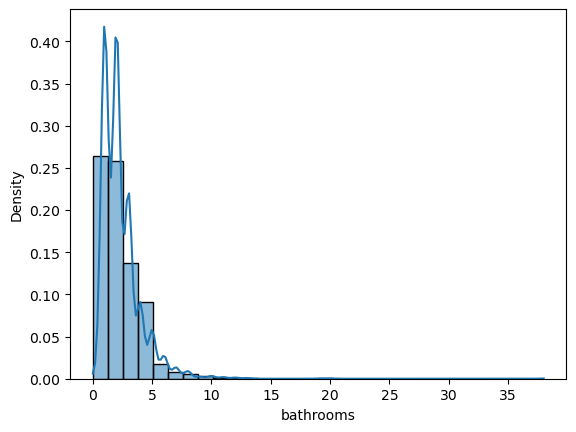

In [332]:
sns.histplot(viviendas_df['bathrooms'],kde=True, stat='density', bins=30);

#### Visualización de la distribución (Boxplot)

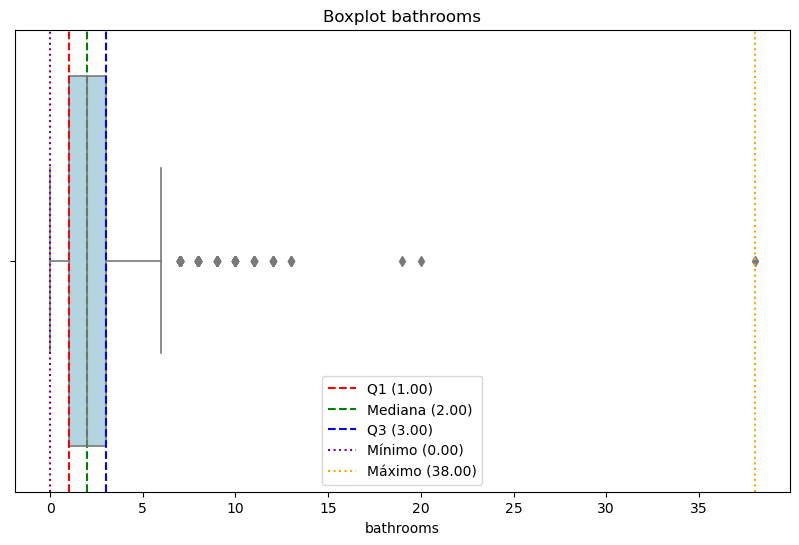

In [333]:
mostrar_boxplot(viviendas_df,'bathrooms')

#### Observaciones:

 - En el análisis de la variable numérica bathrooms, se observa que la mayoría de las viviendas tienen entre 1 y 3 baños, con un promedio de 2,39 baños. La alta desviación estándar indica que hay viviendas con un número de baños significativamente superior al promedio. Además, el rango máximo es notablemente alto, sugiriendo la existencia de propiedades con un número inusualmente elevado de baños. La media (2,39) está cerca de la mediana (2), lo que indica que los datos están relativamente centrados en torno al valor de 2.

#### Variable priceByArea

Calculamos las estadísticas descriptivas de la columna price, incluyendo la media, mediana, desviación estándar, mínimo, máximo y percentiles, para entender su distribución y características.

In [334]:
viviendas_df['priceByArea'].describe()

count     4632.000000
mean      3410.609240
std       2530.440028
min         41.000000
25%       1739.000000
50%       2598.000000
75%       4245.750000
max      20087.000000
Name: priceByArea, dtype: float64

#### Visualización de la distribución( Histograma)

Representamos la distribución de la columna price utilizando una visualización que combina un histograma con una estimación de densidad de kernel (KDE)

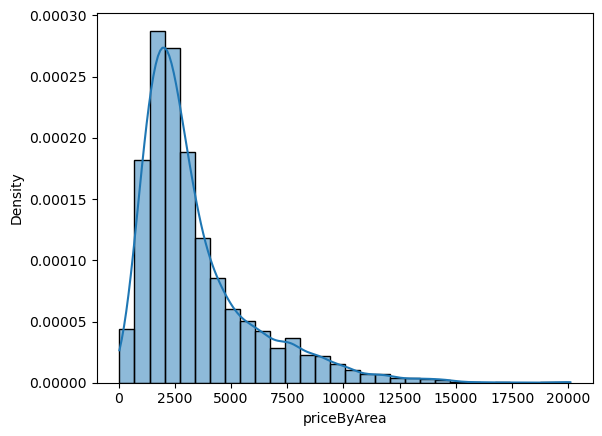

In [335]:
sns.histplot(viviendas_df['priceByArea'],kde=True, stat='density', bins=30);

#### Visualización de la distribución (Boxplot)

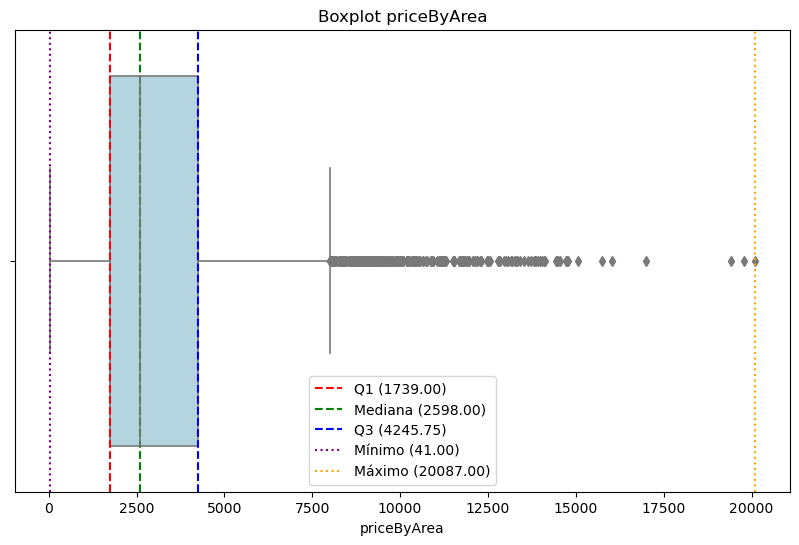

In [336]:
mostrar_boxplot(viviendas_df,'priceByArea')

#### Observaciones:

 - En el análisis de la variable numérica priceByArea, se observa una alta variabilidad en el precio por metro cuadrado, con un promedio de 3.448,55 euros. La desviación estándar indica una amplia gama de valores, desde precios muy bajos hasta extremadamente altos, lo que refleja una gran disparidad en los precios por metro cuadrado de las propiedades. La media (3.448,55) es notablemente superior a la mediana (2.631), lo que sugiere que la distribución de los datos está sesgada hacia la derecha.

#### Variable longitude

Calculamos las estadísticas descriptivas de la columna price, incluyendo la media, mediana, desviación estándar, mínimo, máximo y percentiles, para entender su distribución y características.

In [338]:
viviendas_df['longitude'].describe()

count    4632.000000
mean       -3.721321
std         0.217481
min        -4.491436
25%        -3.808292
50%        -3.697590
75%        -3.623172
max        -3.091176
Name: longitude, dtype: float64

#### Visualización de la distribución( Histograma)

Representamos la distribución de la columna price utilizando una visualización que combina un histograma con una estimación de densidad de kernel (KDE)

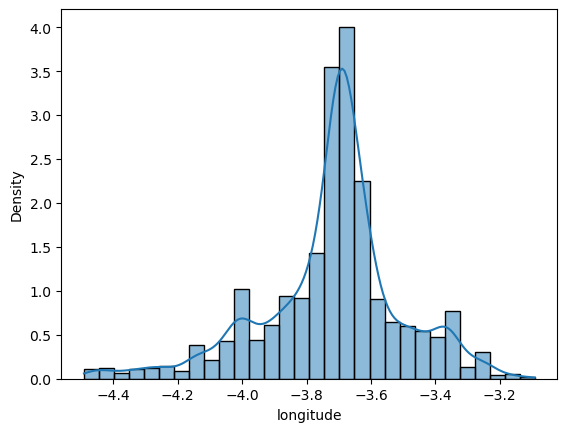

In [339]:
sns.histplot(viviendas_df['longitude'],kde=True, stat='density', bins=30);

#### Visualización de la distribución (Boxplot)

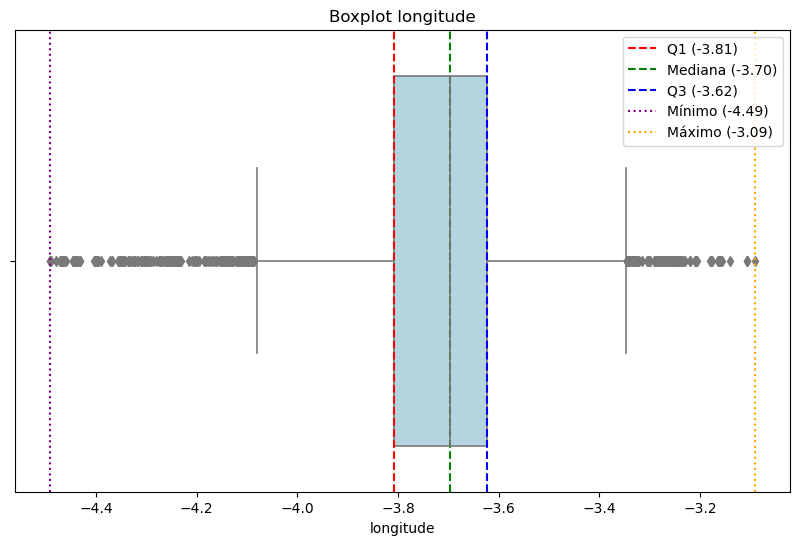

In [340]:
mostrar_boxplot(viviendas_df,'longitude')

#### Observaciones:

 - En el análisis de la variable numérica longitude, se observa que el promedio de longitud es aproximadamente -3.721521. El 25% de los datos se sitúan por debajo de -3.804025, mientras que el 75% están por debajo de -3.624403. Esto sugiere que las ubicaciones dentro del conjunto de datos están bastante concentradas en una región geográfica relativamente pequeña. La media (-3,721521) es ligeramente menor que la mediana (-3,697920), indicando que la distribución podría ser relativamente simétrica, aunque con una ligera inclinación hacia valores menores (sesgo negativo).

#### Variable latitude

Calculamos las estadísticas descriptivas de la columna price, incluyendo la media, mediana, desviación estándar, mínimo, máximo y percentiles, para entender su distribución y características.

In [341]:
viviendas_df['latitude'].describe()

count    4632.000000
mean       40.439493
std         0.147011
min        40.020862
25%        40.362598
50%        40.428464
75%        40.500550
max        41.131571
Name: latitude, dtype: float64

#### Visualización de la distribución( Histograma)

Representamos la distribución de la columna price utilizando una visualización que combina un histograma con una estimación de densidad de kernel (KDE)

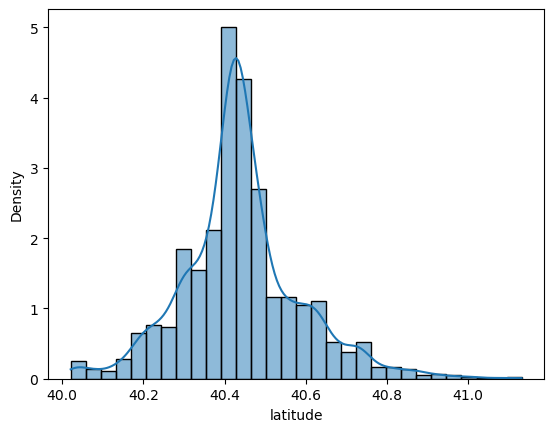

In [342]:
sns.histplot(viviendas_df['latitude'],kde=True, stat='density', bins=30);

#### Visualización de la distribución (Boxplot)

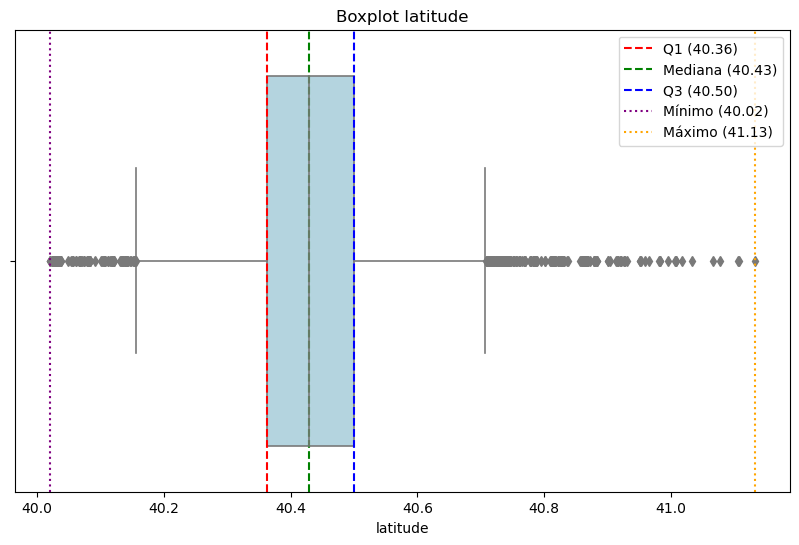

In [343]:
mostrar_boxplot(viviendas_df,'latitude')

#### Observaciones:

 - En el análisis de la variable numérica latitude, se observa que el promedio de latitud es aproximadamente 40.440697. La mayoría de las latitudes se agrupan alrededor de este valor medio, con el 25% de los datos situados por debajo de 40.366701 y el 75% por debajo de 40.501562. Esto sugiere que las ubicaciones en el conjunto de datos están concentradas en una región geográfica relativamente pequeña. La media (40,44) es ligeramente menor que la mediana (40,50), indicando que la distribución de las latitudes es relativamente simétrica, aunque con una ligera inclinación hacia valores menores (sesgo negativo).

Diagrama de dispersion de Latitud y Longitud

<Axes: xlabel='longitude', ylabel='latitude'>

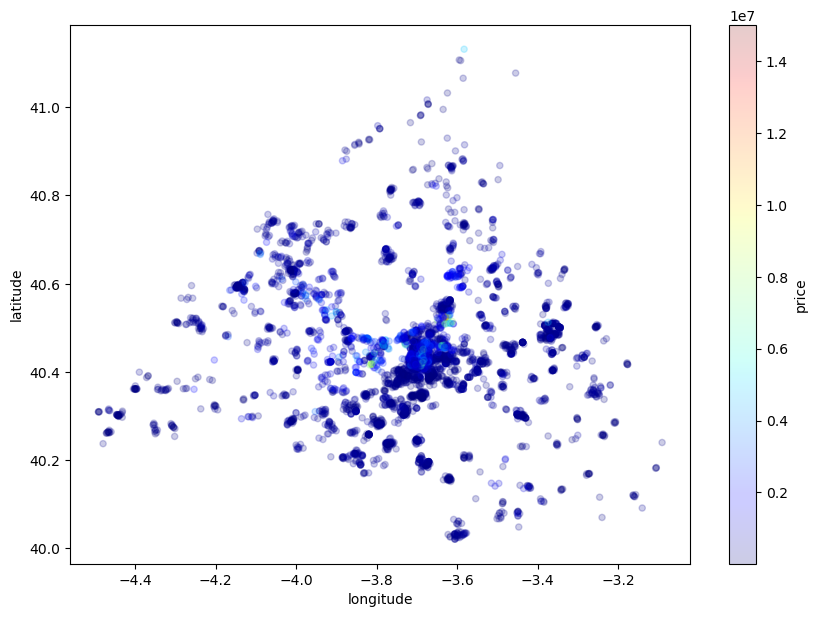

In [344]:
viviendas_df.plot(kind='scatter',x='longitude', alpha=0.2, y='latitude', figsize=(10,7),
                 c='price',cmap=plt.get_cmap('jet'),colorbar=True)

Mapa de Localización de las Viviendas

In [345]:
mapa=folium.Map(location=[40.4168,-3.7038])
viviendas = viviendas_df[['latitude','longitude']].to_numpy()
HeatMap(viviendas, radius=15, max_val=0.1, min_opacity=0.4).add_to(mapa)
mapa

C:\Users\Arnold\AppData\Local\Temp\ipykernel_17716\435830730.py:3: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.
  HeatMap(viviendas, radius=15, max_val=0.1, min_opacity=0.4).add_to(mapa)


##### Observaciones:

Se observa que el conjunto de datos incluye viviendas distribuidas por diversas zonas de la Comunidad de Madrid, lo que indica que el dataset es altamente representativo.
La mayoría de los datos se encuentran dentro del rango de longitud entre -3.8 y -3.4, y latitud entre 40.3 y 40.6. Esta concentración indica que las viviendas están predominantemente situadas en una región geográfica específica dentro de la Comunidad de Madrid. 

### Variables Categóricas Simples

Mostrar graficos de barras del conteo de variables categoricas

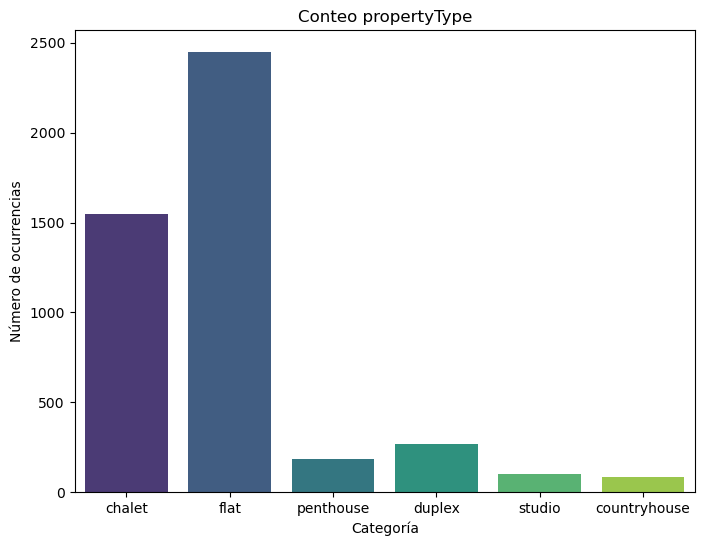

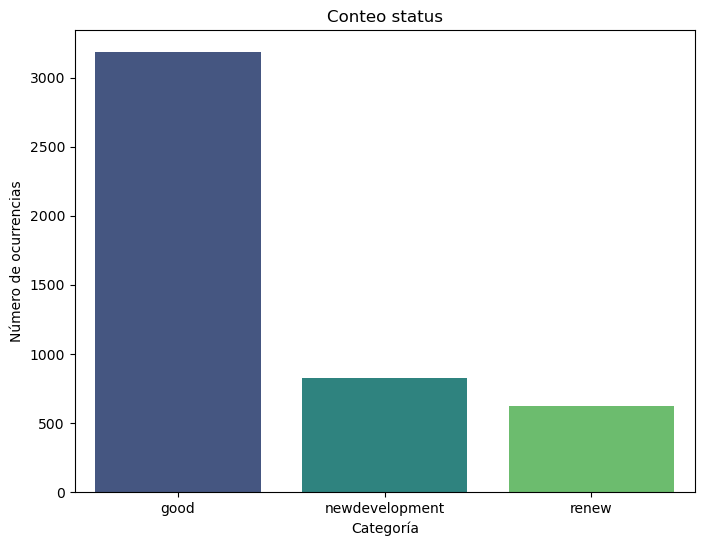

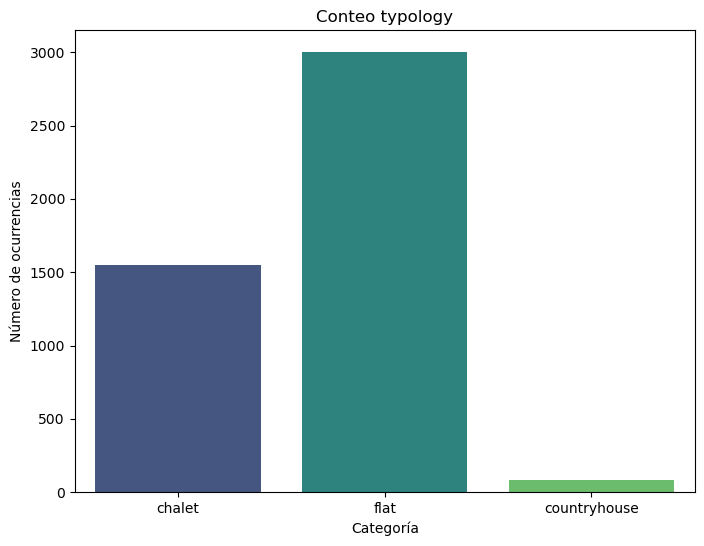

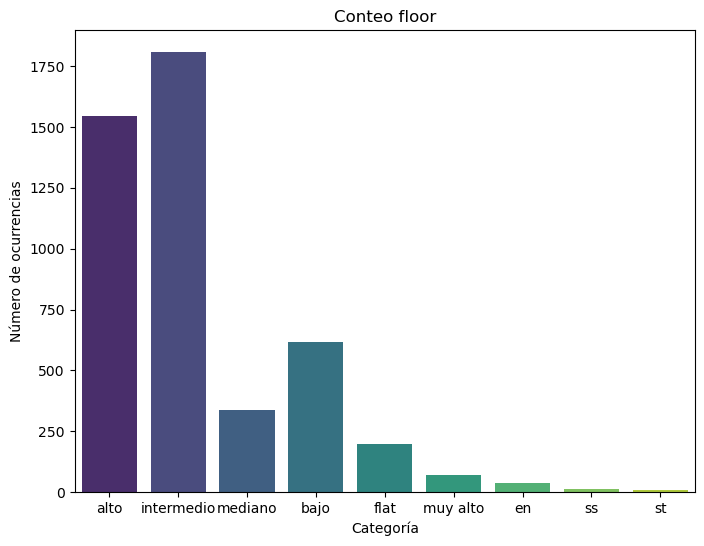

In [346]:
mostrar_conteos_categorias(viviendas_df,['description','address','subtitle','title','municipality'])

### Observaciones

#### Análisis de la variable `hasParkingSpace`

En el análisis de la variable categórica `hasParkingSpace`, que es de tipo booleano, se observa que contiene únicamente valores `True` en los registros no nulos. Esto indica que el aparcamiento está siempre disponible en los datos disponibles. Dado que esta columna puede ser importante en el precio de la vivienda y que en la mayoria de los casos cuando no se especifica el parking es porque realmente no lo tiene por lo que se procede a reemplazar los nulos por false.

#### Análisis de la variable `isParkingSpaceIncludedInPrice`

En el análisis de la variable categórica `isParkingSpaceIncludedInPrice`, se presenta un 50% de valores nulos, lo que limita su utilidad y puede complicar el análisis. Además, la información sobre la inclusión del aparcamiento en el precio está parcialmente dependiente de la columna `hasParkingSpace`, la cual también tiene problemas de datos nulos. Por estas razones, se procede a reemplazar los valores nulos que no tienen parking a false.

#### Análisis de la variable `propertyType`

En el análisis de la variable categórica `propertyType`, se identificaron seis niveles distintos: `chalet`, `flat`, `penthouse`, `duplex`, `studio` y `countryhouse`.

La distribución de los estados de las viviendas en el conjunto de datos revela lo siguiente:

- **Tipo de vivienda (`flat`)**: Este tipo de propiedad es el más común, con una presencia destacada en el conjunto de datos, superando las 2000 unidades.
- **Tipo de vivienda (`chalet`)**: A continuación, se encuentra el tipo `chalet`, con aproximadamente 1500 viviendas registradas.

#### Análisis de la variable `status`

En el análisis de la variable categórica `status`, se identificaron tres niveles distintos:

- `good`
- `newDevelopment`
- `renew`

La distribución de los estados de las viviendas en el conjunto de datos revela lo siguiente:

- **Estado `good`**: Este estado es el más prevalente, con más de 3000 viviendas clasificadas bajo esta categoría.
- **Estado `newDevelopment` y `renew`**: Tienen una presencia significativamente menor, con menos de 1000 viviendas en total para cada uno de estos estados.

#### Análisis de la variable `typology`

En el análisis de la variable categórica `typology`, se identificaron tres niveles distintos:

- `chalet`
- `flat`
- `countryhouse`

La distribución de los tipos de vivienda en el conjunto de datos revela lo siguiente:

- **Tipo de vivienda (`flat`)**: Este tipo de propiedad es el más común, con una presencia destacada en el conjunto de datos, superando las 2500 unidades. Esta alta frecuencia también se refleja en la columna `propertyType`, donde `flat` es el tipo de vivienda predominante.
- **Tipo de vivienda (`chalet`)**: El siguiente tipo en términos de frecuencia es `chalet`, con aproximadamente 1500 viviendas registradas.
- **Tipo de vivienda (`countryhouse`)**: Este tipo de propiedad tiene una presencia mucho menor en el conjunto de datos, con muy pocos registros en comparación con los tipos `flat` y `chalet`.

#### Análisis de la variable `floor`

En el análisis de la variable categórica `floor`, se observa que más de 1400 viviendas están categorizadas como `chalet`. El resto de las viviendas se distribuye entre las categorías `número de planta` y `countryhouse`.

- **Categoría (`chalet`)**: Esta categoría representa más de 1400 viviendas, lo que indica que una parte significativa del conjunto de datos está clasificada bajo este tipo.
- **Distribución del resto**: Las viviendas restantes se distribuyen entre la categoría `número de planta` y `countryhouse`, aunque con una representación menor en comparación con `chalet`.

#### Análisis de la variable `hasLift`

En el análisis de la variable categórica `hasLift`, que es de tipo booleano, se observa que la distribución entre las categorías `True` y `False` es relativamente homogénea.


#### Observaciones: 
  - Ya no existen datos faltantes en el conjunto de datos

### Variables Categóricas complejas

Para el análisis de las variables categóricas complejas, se procederá a contar las palabras más frecuentes. Para ello, se llevará a cabo un preprocesamiento del texto, que se realizará mediante la función procesarTexto y que incluye las siguientes etapas:

  - **Limpieza del Texto**: Eliminación de caracteres especiales, como la puntuación y las palabras que aportan poco significado en el análisis de texto.
  - **Tokenización**: División del texto en palabras o tokens.
  - **Lematización/Stemming**: Reducción de las palabras a su raíz.

Se procesará el texto de la columna municipality y se almacenará el resultado en una nueva columna denominada processed_municipality

In [347]:
processed_municipality = viviendas_df['municipality'].apply(lambda texto:procesar_texto(texto,stop_words_es))

Se muestra un gráfico de barras que presenta las 15 palabras más frecuentes de la columna

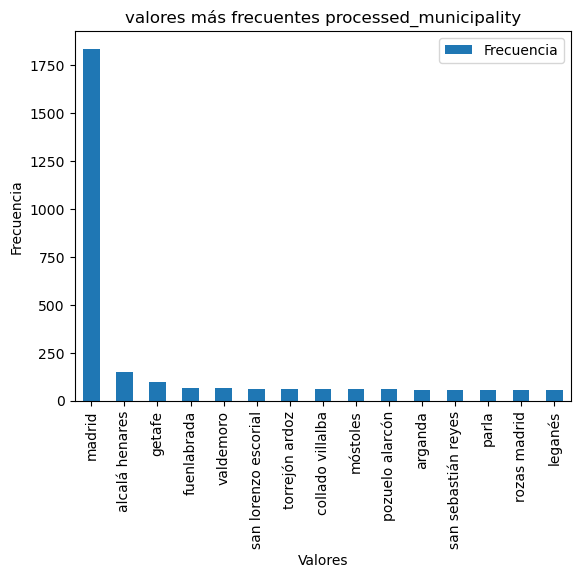

In [348]:
valores_mas_frecuentes(processed_municipality,'processed_municipality',15)

#### Observaciones:
 
 - Se puede observar que el mayor número de viviendas se encuentra en Madrid. Esta observación se confirma al revisar el gráfico de dispersión, que mostró una alta concentración de viviendas en ciertas áreas, aunque no permitía identificar con precisión las zonas específicas.

Se procesará el texto de la columna address y se almacenará el resultado en una nueva columna denominada processed_address

In [349]:
processed_address = viviendas_df['address'].apply(lambda texto:procesar_texto(texto,stop_words_es))

Se muestra un gráfico de barras que presenta las 15 valores más frecuentes de la columna

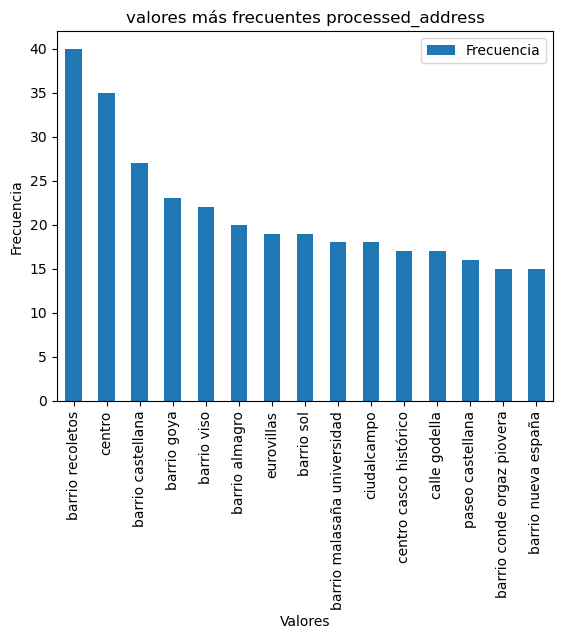

In [350]:
valores_mas_frecuentes(processed_address,'processed_address',15)

#### Observaciones:

 - Esta gráfica confirma los resultados de la gráfica anterior, al mostrar que la mayoría de los barrios están ubicados en el municipio de Madrid.

Se procesará el texto de la columna subtitle y se almacenará el resultado en una nueva columna denominada processed_subtitle

In [351]:
processed_subtitle = viviendas_df['subtitle'].apply(lambda texto:procesar_texto(texto,stop_words_es))

Se muestra un gráfico de barras que presenta las 15 valores más frecuentes de la columna

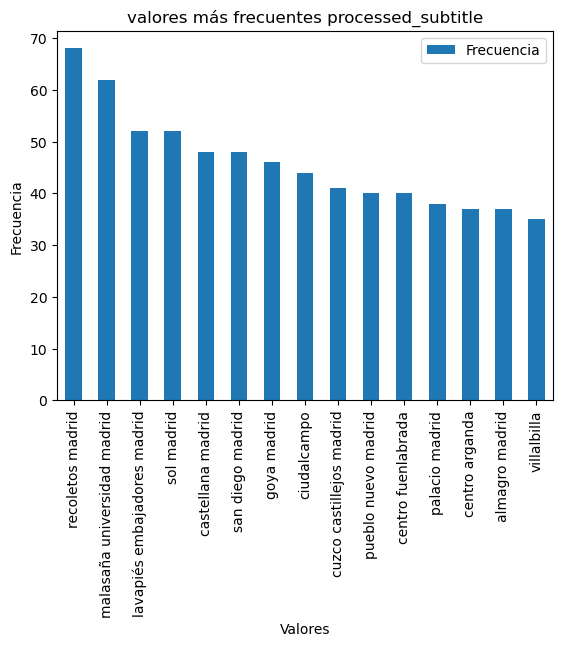

In [352]:
valores_mas_frecuentes(processed_subtitle,'processed_subtitle',15)

#### Observaciones:

 - Esta gráfica confirma los resultados de la gráfica anterior, al mostrar que la mayoría de los barrios están ubicados en la ciudad de Madrid.

Se procesará el texto de la columna title y se almacenará el resultado en una nueva columna denominada processed_title

In [353]:
processed_description = viviendas_df['description'].apply(lambda texto:procesar_texto(texto,stop_words_es))

Se presenta un gráfico de barras que muestra las 20 palabras más frecuentes de longitud superior a 4 caracteres

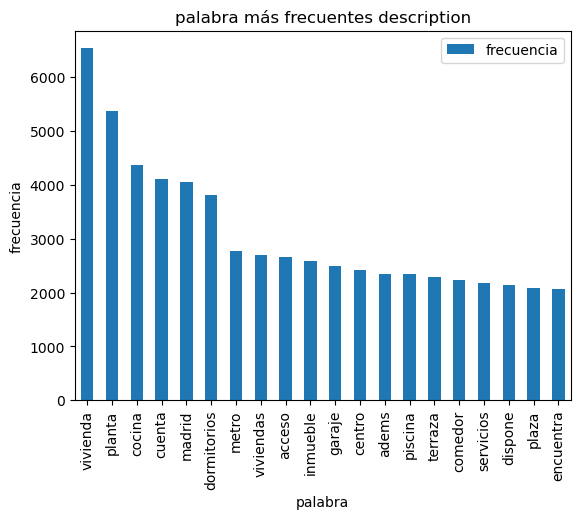

In [354]:
frecuencia_palabras(processed_description,'description',20,5)

#### Observaciones:

 - En esta gráfica de barra se pueden observar palabras frecuentes como "vivienda", "planta", "cocina", "dormitorios", "garaje" y "servicios", entre otras. Estas palabras reflejan características clave de las viviendas, las cuales se encuentran en la columna "descripción" del conjunto de datos. Esta información es relevante, ya que puede ser útil para el entrenamiento del modelo, proporcionando detalles adicionales que podrían mejorar su rendimiento al capturar aspectos importantes de las viviendas.

Se procesará el texto de la columna title y se almacenará el resultado en una nueva columna denominada processed_title

In [355]:
processed_title = viviendas_df['title'].apply(lambda texto:procesar_texto(texto,stop_words_es))

Se muestra un gráfico de barras que presenta las 15 valores más frecuentes de la columna

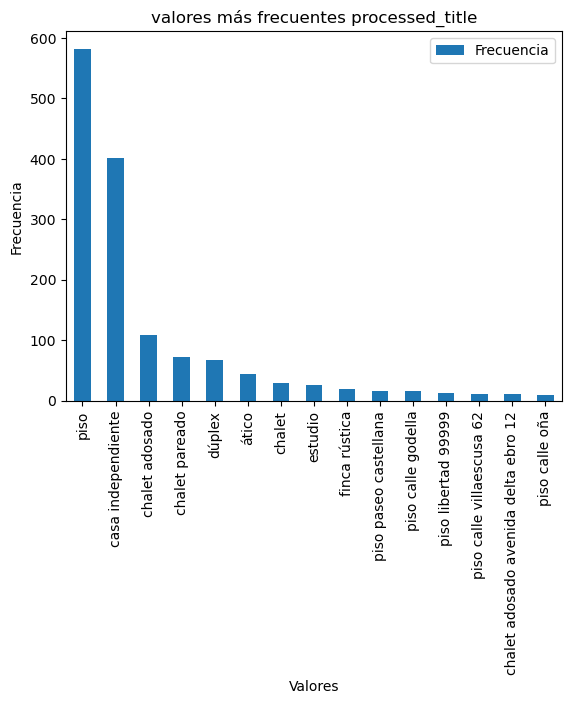

In [356]:
valores_mas_frecuentes(processed_title,'processed_title',15)

#### Observaciones:

 - En esta gráfica de barra se puede observar que los valores más frecuentes dentro del conjunto de datos son "piso" y "casa independiente".

Despues realizar una analisis de las variables categoricas complejas, se procede a eliminar las columnas:

- **title y subtitle**: porque la informacion que presenta esta mezclado y como no se utilizara un procesamiento de texto para transformarlo a numerico.
- **address**: con las columnas latitud y longitud ya cubre la informacion de la direccion.
- **description**: Aunque la columna descripción puede proporcionar mucha informacion pero se va a utilizar un procesamiento de texto para transformarlo a numerico por lo que lo vamos a eliminar.

Se procede a eliminar las columnas title puesto que la información no es relevante para el problema. También se elimina la columna address puesto que ya tenemos esa información con las coordenadas

In [357]:
viviendas_limpieza_df = viviendas_df.drop(columns=['title','address'])

Se procede a eliminar la columna descripcion a pesar de que puede aportar informacion valiosa pero no se utilizara un embedding para codificar el texto

In [358]:
viviendas_limpieza_df = viviendas_limpieza_df.drop(columns=['description'])

En en la columna subtitle se ha observado que hay dos valores separados por comas y que el primer valor representa una informacion importante respecto al distrito.Se procede a realizar una separacion del valor de la columna subtitle por comas y quedarnos con el primer valor

In [359]:
viviendas_limpieza_df['subtitle'] = viviendas_limpieza_df['subtitle'].str.split(',').str[0].str.strip()

***revisar observaciones de la distribucion porque estan mal
latitud y longitud
variables categorico ver la distribucion mediante histogramas o boxplot pero para ellos se tiene que
 una funcion que obtengar un recuento de palabras, la frecuencias***

### Análisis Multivariable

Se procederá a realizar un análisis multivariable para explorar la relación entre el precio de la vivienda y otras variables relevantes en el conjunto de datos. Este análisis tiene como objetivo identificar cómo las variables independientes influyen en el precio de la vivienda y determinar las correlaciones más significativas entre ellas.

#### Matriz de Correlación: Representación Numérica y Visual

Se utiliza gráfico de heatmap para visualizar la matriz de correlación, mostrando la relación entre el precio de la vivienda y cada una de las variables independientes 

C:\Users\Arnold\AppData\Local\Temp\ipykernel_17716\615034486.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(viviendas_limpieza_df.corr(),annot=True, fmt=".2f", cmap='coolwarm', center=0);


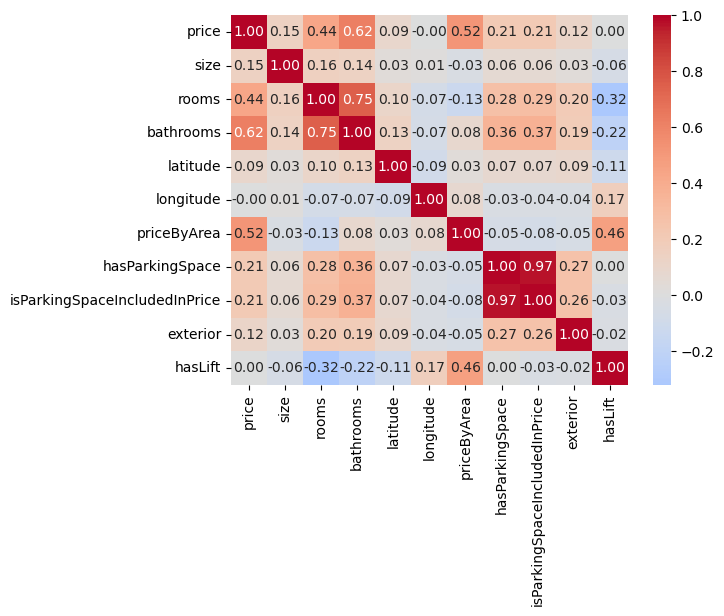

In [360]:
sns.heatmap(viviendas_limpieza_df.corr(),annot=True, fmt=".2f", cmap='coolwarm', center=0);

##### Observaciones:

En el análisis de correlación entre el precio (`price`) y las variables predictoras, se observaron los siguientes coeficientes de correlación:

- **precio y tamaño (`size`)**: La correlación entre el precio y el tamaño de las viviendas es de **0.15**. Este valor indica una correlación positiva débil, sugiriendo que, en general, a medida que el tamaño de la vivienda aumenta, el precio tiende a aumentar también, aunque la relación no es particularmente fuerte.

- **precio y número de habitaciones (`rooms`)**: La correlación entre el precio y el número de habitaciones es de **0.44**. Este coeficiente muestra una correlación positiva moderada, lo que sugiere que el precio de la vivienda tiene una relación más significativa con el número de habitaciones. A medida que el número de habitaciones aumenta, el precio tiende a incrementarse de manera más notable.

- **precio y número de baños (`bathrooms`)**: La correlación entre el precio y el número de baños es de **0.62**. Esta es una correlación positiva fuerte, indicando que el precio de la vivienda está bastante relacionado con el número de baños. Un mayor número de baños generalmente está asociado con un precio más alto.

- **precio y latitud (`latitude`)**: La correlación entre el precio y la latitud es de **0.09**. Este valor sugiere una correlación positiva muy débil, indicando que la latitud tiene una influencia casi nula en el precio de las viviendas en el conjunto de datos.

- **precio y precio por metros cuadrados (`priceByArea`)**: La correlación entre el precio y el precio por metro cuadrado es de **0.52**. Esta correlación positiva moderada indica que el precio de la vivienda muestra una relación considerable con la longitud, sugiriendo que la ubicación geográfica (específicamente en términos de longitud) tiene un impacto notable en los precios.

- **precio y presencia de ascensor (`haslift`)**: La correlación entre el precio y la presencia de ascensor es de **-0.00**. Este valor cercano a cero indica que no hay una relación discernible entre la presencia de un ascensor y el precio de la vivienda en el conjunto de datos.


En el análisis de correlación entre las variables predictoras, se observaron los siguientes coeficientes de correlación:


- **tamaño (`size`) y número de habitaciones (`rooms`)**: La correlación entre el tamaño y el número de habitaciones es de **0.16**. Este valor indica una correlación positiva débil, sugiriendo que hay una ligera tendencia a que un mayor tamaño esté asociado con un mayor número de habitaciones, aunque la relación es poco significativa.

- **tamaño (`size`) y número de baños (`bathrooms`)**: La correlación entre el tamaño y el número de baños es de **0.14**. Este coeficiente refleja una correlación positiva muy débil, indicando que el tamaño de la vivienda tiene una relación casi nula con el número de baños.

- **número de habitaciones (`rooms`) y número de baños (`bathrooms`)**: La correlación entre el número de habitaciones y el número de baños es de **0.75**. Esta es una correlación positiva fuerte, indicando que a medida que aumenta el número de habitaciones, también aumenta significativamente el número de baños. Esto sugiere que las viviendas con más habitaciones tienden a tener más baños.

- **número de habitaciones (`rooms`) y latitud (`latitude`)**: La correlación entre el número de habitaciones y la latitud es de **0.10**. Este valor indica una correlación positiva muy débil, sugiriendo que la ubicación en términos de latitud tiene una influencia casi nula sobre el número de habitaciones.

- **número de habitaciones (`rooms`) y precio por área (`priceByArea`)**: La correlación entre el número de habitaciones y el precio por área es de **-0.13**. Este coeficiente negativo débil indica una ligera relación inversa, sugiriendo que un mayor número de habitaciones podría estar asociado con un menor precio por área, aunque la relación es muy débil.

- **número de habitaciones (`rooms`) y presencia de ascensor (`haslift`)**: La correlación entre el número de habitaciones y la presencia de ascensor es de **-0.32**. Este valor muestra una correlación negativa moderada, indicando que las viviendas con más habitaciones tienden a tener menos probabilidad de tener un ascensor, aunque la relación no es extremadamente fuerte.

- **número de habitaciones (`rooms`) y longitud (`longitude`)**: La correlación entre el número de habitaciones y la longitud es de **-0.07**. Este valor muy cercano a cero indica que la longitud geográfica tiene una influencia prácticamente nula sobre el número de habitaciones.

- **número de baños (`bathrooms`) y latitud (`latitude`)**: La correlación entre el número de baños y la latitud es de **0.13**. Este valor muestra una correlación positiva débil, indicando que la latitud tiene una ligera influencia sobre el número de baños, aunque la relación es débil.

- **número de baños (`bathrooms`) y longitud (`longitude`)**: La correlación entre el número de baños y la longitud es de **-0.07**. Este coeficiente negativo cercano a cero sugiere que la longitud tiene una influencia prácticamente nula sobre el número de baños.

- **número de baños (`bathrooms`) y precio por área (`priceByArea`)**: La correlación entre el número de baños y el precio por área es de **0.08**. Este valor positivo muy bajo indica que el número de baños tiene una influencia casi nula sobre el precio por área.

- **número de baños (`bathrooms`) y presencia de ascensor (`haslift`)**: La correlación entre el número de baños y la presencia de ascensor es de **-0.22**. Este coeficiente negativo sugiere una correlación débil negativa, indicando que las viviendas con más baños tienden a tener una menor probabilidad de tener un ascensor.

- **latitud (`latitude`) y longitud (`longitude`)**: La correlación entre la latitud y la longitud es de **-0.09**. Este coeficiente indica una correlación negativa muy débil, sugiriendo que la latitud y la longitud tienen una relación casi nula en el conjunto de datos.

- **latitud (`latitude`) y presencia de ascensor (`haslift`)**: La correlación entre la latitud y la presencia de ascensor es de **-0.11**. Este valor refleja una correlación negativa muy débil, indicando que la latitud tiene una influencia casi nula sobre la presencia de un ascensor.

- **longitud (`longitude`) y precio por área (`priceByArea`)**: La correlación entre la longitud y el precio por área es de **0.08**. Este valor positivo muy bajo indica que la longitud tiene una influencia casi nula sobre el precio por área.

- **longitud (`longitude`) y presencia de ascensor (`haslift`)**: La correlación entre la longitud y la presencia de ascensor es de **0.17**. Este coeficiente refleja una correlación positiva débil, sugiriendo que la longitud tiene una ligera influencia en la presencia de un ascensor.

- **precio por área (`priceByArea`) y presencia de ascensor (`haslift`)**: La correlación entre el precio por área y la presencia de ascensor es de **0.46**. Este coeficiente indica una correlación positiva moderada, sugiriendo que un mayor precio por área está asociado con una mayor probabilidad de tener un ascensor.


##### Conclusión: 

Con estos resultados de la correlacion se puede apreciar que hay muy pocos valores que tiene una influencia respecto del precio de la vivienda por lo que se procede a realizar una proceso de discretacion de algunas variables y eliminación de valores atipicos.


Se procede a categorizar la columna size en pequeño, mediano, grande y muy grande

In [361]:
#viviendas_limpieza_df['size'] = viviendas_limpieza_df['size'].apply(clasificar_tamaño)

Se procede a eliminar los valores atipico de la columnas

In [362]:
viviendas_limpieza_df = eliminarOutliersColumnas(viviendas_limpieza_df, ['price','rooms','bathrooms','priceByArea','size'])

Se puede observar que el conjunto de dato se ha reducido a 3.338 registros con 20 columnas

In [363]:
viviendas_limpieza_df.shape

(3256, 17)

Se procede a ejecutar de nuevo la correlacion

C:\Users\Arnold\AppData\Local\Temp\ipykernel_17716\615034486.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(viviendas_limpieza_df.corr(),annot=True, fmt=".2f", cmap='coolwarm', center=0);


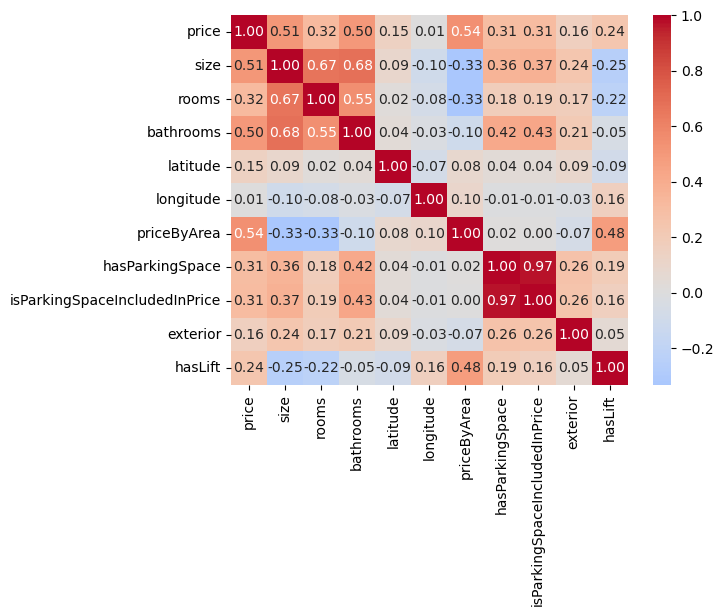

In [364]:
sns.heatmap(viviendas_limpieza_df.corr(),annot=True, fmt=".2f", cmap='coolwarm', center=0);

##### Observaciones:

En el análisis de correlación entre el precio (`price`) y las variables predictoras, se observaron los siguientes coeficientes de correlación:

- **precio y tamaño (`size`)**: La correlación entre el precio y el tamaño de las viviendas es de **0.51**. Este valor indica una correlación positiva moderada, sugiriendo que, en general, a medida que el tamaño de la vivienda aumenta, el precio tiende a aumentar también.

- **precio y número de habitaciones (`rooms`)**: La correlación entre el precio y el número de habitaciones es de **0.32**. Este coeficiente muestra una correlación positiva moderada, lo que sugiere que el precio de la vivienda tiene una relación más significativa con el número de habitaciones. A medida que el número de habitaciones aumenta, el precio tiende a incrementarse de manera más notable.

- **precio y número de baños (`bathrooms`)**: La correlación entre el precio y el número de baños es de **0.50**. Esta es una correlación positiva moderada, indicando que el precio de la vivienda está bastante relacionado con el número de baños. Un mayor número de baños generalmente está asociado con un precio más alto.

- **precio y precio por metros cuadarados(`priceByArea`)**: La correlación entre el precio y el precio por metros cuadarados es de **0.54**. Este valor sugiere una correlación positiva moderada, indicando que el precio por metros cuadarados tiene una influencia mas sifnificativa en el precio de las viviendas en el conjunto de datos.

- **precio y parking (`hasParkingSpace`)**: La correlación entre el precio y el parking es de **0.31**. Esta correlación positiva moderada indica que el precio de la vivienda muestra una relación considerable con el parking.

- **precio y presencia de ascensor (`haslift`)**: La correlación entre el precio y la presencia de ascensor es de **0.24**. Esta correlación positiva moderada indica que el precio de la vivienda muestra una relación considerable con la presencia del ascensor.

- **precio y exterior (`exterior`)**: La correlación entre el precio y el código postal es de **0.16**. Esta correlación positiva moderada indica que el precio de la vivienda muestra una relación considerable con el exterior.


En el análisis de correlación entre las variables predictoras, se observaron los siguientes coeficientes de correlación:


- **tamaño (`size`) y número de habitaciones (`rooms`)**: La correlación entre el tamaño y el número de habitaciones es de **0.67**. Este valor indica una correlación positiva fuerte, sugiriendo que hay una tendencia a que un mayor tamaño esté asociado con un mayor número de habitaciones.

- **tamaño (`size`) y número de baños (`bathrooms`)**: La correlación entre el tamaño y el número de baños es de **0.68**. Este coeficiente refleja una correlación positiva fuerte, indicando que el tamaño de la vivienda tiene una relación significativa con el número de baños.

- **número de habitaciones (`rooms`) y número de baños (`bathrooms`)**: La correlación entre el número de habitaciones y el número de baños es de **0.55**. Esta es una correlación positiva moderada, indicando que a medida que aumenta el número de habitaciones, también aumenta significativamente el número de baños. Esto sugiere que las viviendas con más habitaciones tienden a tener más baños.

- **número de habitaciones (`rooms`) y precio por área (`priceByArea`)**: La correlación entre el número de habitaciones y el precio por área es de **-0.33**. Este coeficiente negativo moderada indica una relación inversa, sugiriendo que un mayor número de habitaciones podría estar asociado con un menor precio por área, aunque la relación es muy débil.

- **número de habitaciones (`rooms`) y presencia de ascensor (`haslift`)**: La correlación entre el número de habitaciones y la presencia de ascensor es de **-0.22**. Este valor muestra una correlación negativa moderada, indicando que las viviendas con más habitaciones tienden a tener menos probabilidad de tener un ascensor, aunque la relación no es extremadamente fuerte.


- **latitud (`latitude`) y longitud (`longitude`)**: La correlación entre la latitud y la longitud es de **-0.07**. Este coeficiente indica una correlación negativa muy débil, sugiriendo que la latitud y la longitud tienen una relación casi nula en el conjunto de datos.

- **precio por área (`priceByArea`) y presencia de ascensor (`haslift`)**: La correlación entre el precio por área y la presencia de ascensor es de **0.48**. Este coeficiente indica una correlación positiva moderada, sugiriendo que un mayor precio por área está asociado con una mayor probabilidad de tener un ascensor.


##### Conclusión: 

Se puede apreciar que la correlacion de las variables respecto del precio ha mejorado bastante.


Se guardará el conjunto de datos en un archivo CSV para facilitar su uso en el desarrollo del modelo predictivo

In [365]:
csv_path = 'datos_procesados/viviendas_procesadas_df.csv'
viviendas_limpieza_df.to_csv(csv_path, index=False)